Curso:<br>
https://cursos.alura.com.br/course/spark-sistema-recomendacao<br>

Dataset:<br>
https://caelum-online-public.s3.amazonaws.com/2278-spark-sistema-recomendacao/01/dados_musicas.csv<br>

Referência dos dados:<br>
https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features

# Dicionário de Dados

| Variável | Descrição |
| :- | :- |
| Acousticness/Acústica | variável numérica; medida de confiança de 0,0 a 1,0 se a faixa é acústica. O 1.0 representa alta confiança de que a faixa é acústica. |
| Danceability/Dançabilidade | variável numérica; a dançabilidade descreve o quão adequada uma faixa é para dançar com base em uma combinação de elementos musicais, incluindo tempo, estabilidade do ritmo, força da batida e regularidade geral. Um valor de 0,0 é o menos e 1,0 é o mais dançável. |
| Duration_ms | variável numérica; a duração da trilha em milissegundos. |
| Duration_min | variável numérica; a duração da faixa em minutos. |
| Energy/Energia | variável numérica; energia é uma medida de 0,0 a 1,0 e representa uma medida perceptiva de intensidade e atividade. Normalmente, as faixas energéticas parecem rápidas, altas e barulhentas. Por exemplo, o death metal tem alta energia, enquanto um prelúdio de Bach tem uma pontuação baixa na escala. As características perceptivas que contribuem para este atributo incluem faixa dinâmica, intensidade percebida, timbre, taxa de início e entropia geral. |
| Explicit/Explícito | variável categórica; se a faixa tem ou não letras explícitas (verdadeiro = sim (1); falso = não(0), não OU desconhecido). |
| Id | o ID do Spotify para a faixa. |
| Instrumentalness/Instrumentalidade | variável numérica; prevê se uma faixa não contém vocais. Os sons “Ooh” e “aah” são tratados como instrumentais neste contexto. Faixas de rap ou de palavras faladas são claramente “vocais”. Quanto mais próximo o valor de instrumentalidade estiver de 1,0, maior a probabilidade de a faixa não conter conteúdo vocal. Valores acima de 0,5 destinam-se a representar faixas instrumentais, mas a confiança é maior à medida que o valor se aproxima de 1,0. |
| Key/Chave | variável numérica; a chave geral estimada da faixa. Os inteiros são mapeados para pitchs usando a notação padrão de Pitch Class. Por exemplo, 0 = C, 1 = C#/Db, 2 = D, e assim por diante. Se nenhuma chave foi detectada, o valor é -1. |
| Liveness/Ao vivo | variável numérica; detecta a presença de um público na gravação. Valores mais altos de vivacidade representam uma probabilidade maior de que a faixa tenha sido executada ao vivo. Um valor acima de 0,8 fornece uma forte probabilidade de que a faixa esteja ativa. |
| Loudness/Volume em dB | variável numérica; volume geral de uma faixa em decibéis (dB). Os valores de volume são calculados em média em toda a faixa e são úteis para comparar o volume relativo das faixas. A sonoridade é a qualidade de um som em relação à sua amplitude (“altura”), por medir a relação entre os picos e depressões de uma onda sonora. Os valores típicos variam entre -60 e 0 db. |
| Mode/Modo | variável numérica; o modo indica a modalidade (maior ou menor) de uma faixa, o tipo de escala da qual seu conteúdo melódico é derivado. Maior é representado por 1 e menor é 0. |
| Popularity/Popularidade | variável numérica; a popularidade de uma faixa é um valor entre 0 e 100, sendo 100 o mais popular. A popularidade é calculada por algoritmo e é baseada, em grande parte, no número total de execuções que a faixa teve e quão recentes são essas execuções. |
| Speechiness/Fala | variável numérica; detecta a presença de palavras faladas em uma faixa. Quanto mais exclusivamente falada a gravação (por exemplo, talk show, audiolivro, poesia), mais próximo de 1,0 será o valor do atributo. Valores acima de 0,66 descrevem faixas que provavelmente são feitas inteiramente de palavras faladas. Valores entre 0,33 e 0,66 descrevem faixas que podem conter música e fala, seja em seções ou em camadas, incluindo casos como música estilo rap. Os valores abaixo de 0,33 provavelmente representam músicas e outras faixas que não são de fala. |
| Tempo | variável numérica; tempo estimado geral de uma faixa em batidas por minuto (BPM). Na terminologia musical, tempo é a velocidade ou ritmo de uma determinada peça e deriva diretamente da duração média da batida. |
| Valence/Valência | variável numérica; medida de 0,0 a 1,0 descrevendo a positividade musical transmitida por uma faixa. Faixas com alta valência soam mais positivas (por exemplo, feliz, alegre, eufórica), enquanto faixas com baixa valência soam mais negativas (como, triste, deprimida, irritada). |
| Year/Ano | ano em que a música foi lançada. |

In [1]:
from pyspark.sql import SparkSession, functions as f
from pyspark.sql.types import FloatType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.functions import vector_to_array
from scipy.spatial.distance import euclidean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName('recommenderSystem').getOrCreate()
spark

24/03/02 11:57:57 WARN Utils: Your hostname, edupmon-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.0.223 instead (on interface wlp0s20f3)
24/03/02 11:57:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/02 11:57:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Carga dos Dados

In [3]:
dados = spark.read.csv('dados_musicas.csv', header = True, sep = ';',
                            inferSchema = True)

In [4]:
dados.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- artists_song: string (nullable = true)



In [5]:
dados.count()

20311

# Verificando nulos

In [6]:
dados.select([f.count(f.when(f.isnull(c), 1)).alias(c)
              for c in dados.columns]).show(vertical = True)

-RECORD 0---------------
 valence          | 0   
 year             | 0   
 acousticness     | 0   
 artists          | 0   
 danceability     | 0   
 duration_ms      | 0   
 energy           | 0   
 explicit         | 0   
 id               | 0   
 instrumentalness | 0   
 key              | 0   
 liveness         | 0   
 loudness         | 0   
 mode             | 0   
 name             | 0   
 popularity       | 0   
 speechiness      | 0   
 tempo            | 0   
 artists_song     | 0   



# Análise do impacto dos anos nas músicas

In [7]:
dados_anos = spark.read.csv('dados_musicas_ano.csv', header = True,
                            inferSchema = True)

dados_anos = dados_anos.filter('year >= 2000')

In [8]:
dados_anos.printSchema()

root
 |-- mode: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- key: integer (nullable = true)



In [9]:
dados_anos.count()

21

In [10]:
# Convertendo do dataframe Spark para Pandas
df_tmp = dados_anos.drop('mode').toPandas()

[Text(0.5, 1.0, 'Variação do loudness nos anos')]

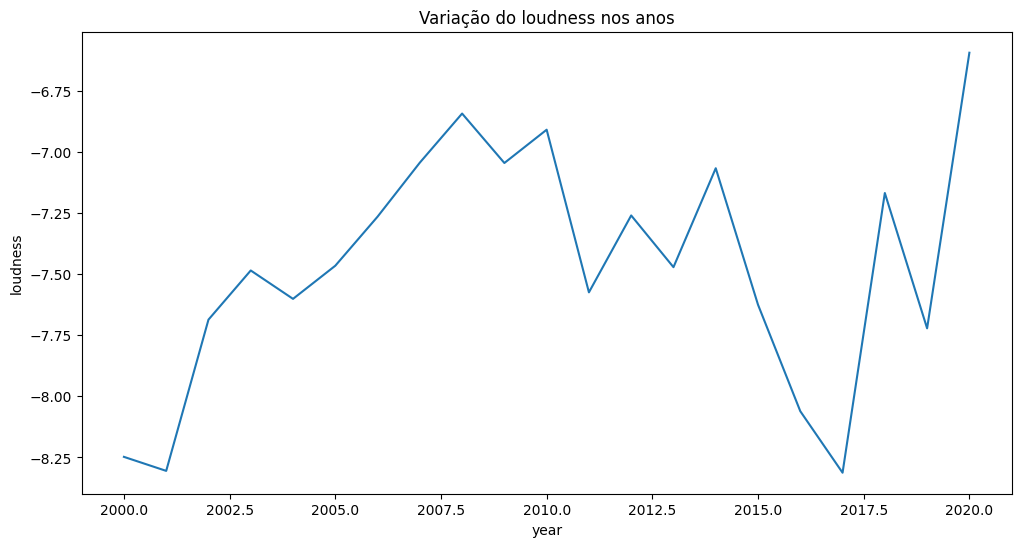

In [11]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x = 'year', y = 'loudness', data = df_tmp)
ax.set(title = 'Variação do loudness nos anos')

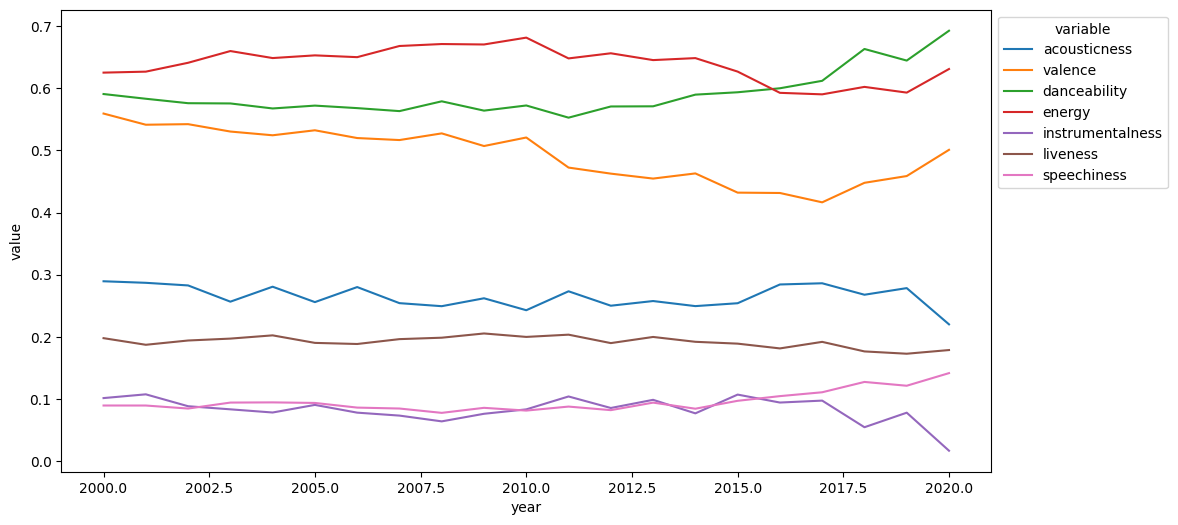

In [12]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x = 'year', y = 'value', hue = 'variable',
                  data = pd.melt(df_tmp[['acousticness', 'valence',
                                         'danceability', 'energy',
                                         'instrumentalness', 'liveness',
                                         'speechiness', 'year']], ['year']))
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

# Análise de correlação

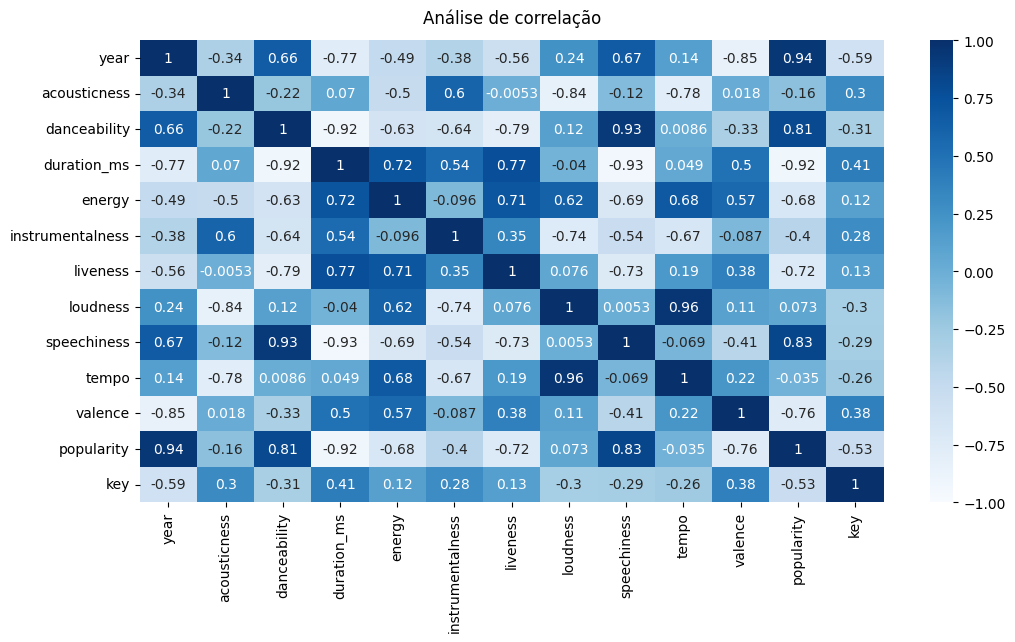

In [13]:
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df_tmp.corr(), vmin = -1, vmax = 1, annot = True,
                      cmap = 'Blues')
heatmap.set_title('Análise de correlação', fontdict={'fontsize': 12},
                  pad = 12);

# Agrupamento por gênero

## PCA e StandardScaler

In [14]:
dados_generos = spark.read.csv('dados_musicas_genero.csv', header = True,
                               inferSchema = True)

In [15]:
dados_generos.count()

2973

In [16]:
dados_generos.select('genres').distinct().count()

2973

In [17]:
dados_generos.printSchema()

root
 |-- mode: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- key: integer (nullable = true)



In [18]:
features = dados_generos.columns
features.remove('genres')
features

['mode',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'popularity',
 'key']

In [19]:
dados_generos_vector = VectorAssembler(inputCols = features,
                                       outputCol = 'features')\
                       .transform(dados_generos).select(['features', 'genres'])

In [20]:
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaled_features')
scaler_model = scaler.fit(dados_generos_vector)
dados_generos_scaler = scaler_model.transform(dados_generos_vector)

24/03/02 11:58:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [21]:
pca = PCA(k = 2, inputCol = 'scaled_features', outputCol = 'pca_features')
pca_model = pca.fit(dados_generos_scaler)
dados_generos_pca = pca_model.transform(dados_generos_scaler)

24/03/02 11:58:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/03/02 11:58:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/03/02 11:58:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [22]:
dados_generos_pca.printSchema()

root
 |-- features: vector (nullable = true)
 |-- genres: string (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



### Opção de execução passos anteriores utilizando um pipeline

In [23]:
stages = [VectorAssembler(inputCols = features, outputCol = 'features'),
          StandardScaler(inputCol = 'features', outputCol = 'scaled_features'),
          PCA(k = 2, inputCol = 'scaled_features', outputCol = 'pca_features')]

pca_pipeline = Pipeline(stages = stages)

In [24]:
pca_pipeline_model = pca_pipeline.fit(dados_generos)

In [25]:
dados_generos_pca_pipeline = pca_pipeline_model.transform(dados_generos)

In [26]:
dados_generos_pca_pipeline.printSchema()

root
 |-- mode: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



## K-Means

In [27]:
kmeans = KMeans(featuresCol = 'pca_features',
                predictionCol = 'cluster_pca').setK(5).setSeed(42)

In [28]:
model_kmeans = kmeans.fit(dados_generos_pca)

In [29]:
predictions_kmeans = model_kmeans.transform(dados_generos_pca)

In [30]:
predictions_kmeans.printSchema()

root
 |-- features: vector (nullable = true)
 |-- genres: string (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)
 |-- cluster_pca: integer (nullable = false)



### Gráfico do Agrupamento

In [31]:
kms = predictions_kmeans.withColumn('x', vector_to_array('pca_features')[0])\
                        .withColumn('y', vector_to_array('pca_features')[1])\
                        .select(['x', 'y', 'cluster_pca', 'genres'])

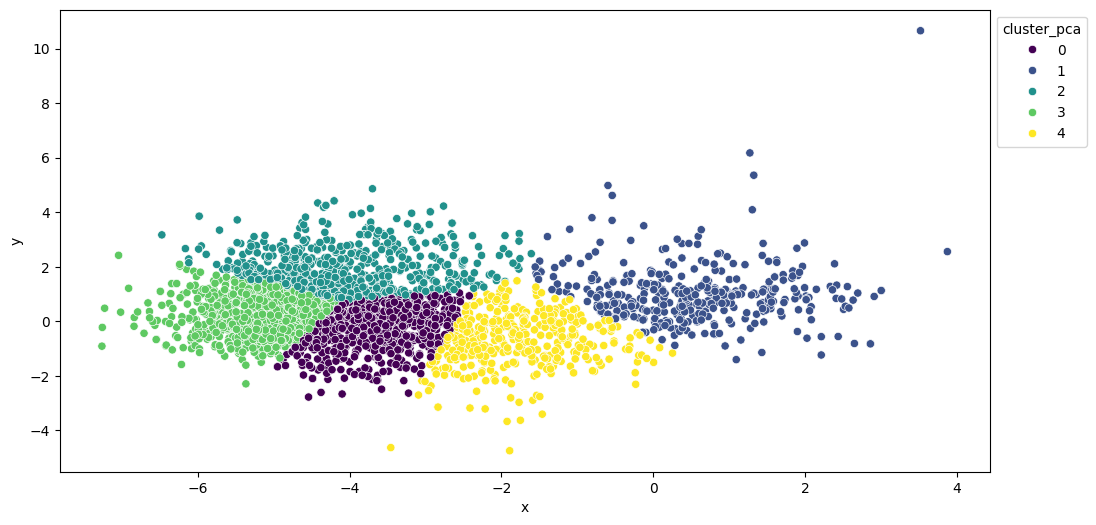

In [32]:
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data = kms.toPandas(), x = 'x', y = 'y',
                     hue = 'cluster_pca', palette = 'viridis')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [33]:
pca_pipeline_model.stages[2].explainedVariance

DenseVector([0.2975, 0.1212])

# Agrupamento por Música

## Redução de Dimensionalidade (Utilizando PCA)

In [34]:
dados.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- artists_song: string (nullable = true)



In [35]:
features = dados.columns
features.remove('artists')
features.remove('id')
features.remove('name')
features.remove('artists_song')
features

['valence',
 'year',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity',
 'speechiness',
 'tempo']

In [36]:
dados_encoded_vector = VectorAssembler(inputCols = features,
                                       outputCol = 'features').transform(dados)

In [37]:
dados_encoded_vector.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- artists_song: string (nullable = true)
 |-- features: vector (nullable = true)



In [38]:
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaled_features')
scaler_model = scaler.fit(dados_encoded_vector)
dados_scaled_features = scaler_model.transform(dados_encoded_vector)

In [39]:
dados_scaled_features.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- artists_song: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)



In [40]:
k = len(features)

pca = PCA(k = k, inputCol = 'scaled_features', outputCol = 'pca_features')
pca_model = pca.fit(dados_scaled_features)
dados_pca = pca_model.transform(dados_scaled_features)

In [41]:
possiveis_k = [sum(pca_model.explainedVariance[0 : i + 1]) for i in range(k)]
possiveis_k

[0.21297354127107343,
 0.34597741622955064,
 0.43989805678254446,
 0.5267820578269102,
 0.6001038103117928,
 0.6665719513652388,
 0.7282174213581727,
 0.7845103843321022,
 0.8350002357002613,
 0.8812446547406768,
 0.9151737562703046,
 0.9435370133056037,
 0.9699018569070159,
 0.9900947792885578,
 0.9999999999999999]

In [42]:
k = sum(np.array(possiveis_k) <= 0.7)
k

6

In [43]:
pca = PCA(k = k, inputCol = 'scaled_features', outputCol = 'pca_features')
pca_model = pca.fit(dados_scaled_features)
dados_pca_final = pca_model.transform(dados_scaled_features)

In [44]:
dados_pca_final.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- artists_song: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



## Agrupamento com o K-Means

In [45]:
stages = [VectorAssembler(inputCols = features, outputCol = 'features'),
          StandardScaler(inputCol = 'features', outputCol = 'scaled_features'),
          PCA(k = k, inputCol = 'scaled_features', outputCol = 'pca_features')]

pca_pipeline = Pipeline(stages = stages)

In [46]:
pca_pipeline_model = pca_pipeline.fit(dados)

In [47]:
projection = pca_pipeline_model.transform(dados)

In [48]:
projection.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- artists_song: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



In [49]:
kmeans = KMeans(k = 50, featuresCol = 'pca_features',
                predictionCol = 'cluster_pca', seed = 42)

In [50]:
modelo_kmeans = kmeans.fit(projection)

In [51]:
projection_kmeans = modelo_kmeans.transform(projection)

In [52]:
projection_kmeans.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- artists_song: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)
 |-- cluster_pca: integer (nullable = false)



## Distância entre Músicas

In [53]:
musica = 'Metallica - The Day That Never Comes'

In [54]:
cluster_musica = projection_kmeans\
                 .filter(projection_kmeans.artists_song == musica)\
                 .select('cluster_pca')\
                 .collect()[0][0]
cluster_musica

23

In [55]:
musicas_cluster = projection_kmeans\
                  .filter(projection_kmeans.cluster_pca == cluster_musica)\
                  .select('artists_song', 'id', 'pca_features')
musicas_cluster.printSchema()

root
 |-- artists_song: string (nullable = true)
 |-- id: string (nullable = true)
 |-- pca_features: vector (nullable = true)



In [56]:
features_musica = musicas_cluster\
                  .filter(musicas_cluster.artists_song == musica)\
                  .select('pca_features')\
                  .collect()[0][0]
features_musica

DenseVector([-35.5519, -164.1696, -9.5173, -138.8579, -14.1436, 3.2967])

In [57]:
def distancia(val):
    return euclidean(features_musica, val)

udf_distancia = f.udf(distancia, FloatType())

In [58]:
musicas_cluster_dist = musicas_cluster\
                       .withColumn('dist',udf_distancia('pca_features'))
musicas_cluster_dist.printSchema()

root
 |-- artists_song: string (nullable = true)
 |-- id: string (nullable = true)
 |-- pca_features: vector (nullable = true)
 |-- dist: float (nullable = true)



In [59]:
musicas_cluster_dist.sort('dist').select('artists_song', 'dist')\
                    .show(truncate = False, n = 11)

+---------------------------------------------+---------+
|artists_song                                 |dist     |
+---------------------------------------------+---------+
|Metallica - The Day That Never Comes         |0.0      |
|Metallica - The End Of The Line              |1.1788932|
|Avenged Sevenfold - The Wicked End           |1.1895529|
|Lamb of God - Blacken the Cursed Sun         |1.3359457|
|Nightwish - Over The Hills And Far Away      |1.4033512|
|Avenged Sevenfold - Sidewinder               |1.4089376|
|Metallica - The Unforgiven III               |1.4154224|
|Gojira - Ocean Planet                        |1.5463531|
|Avenged Sevenfold - Victim                   |1.5597322|
|Bullet For My Valentine - Alone              |1.5967655|
|Pierce The Veil - Tangled In The Great Escape|1.6137474|
+---------------------------------------------+---------+
only showing top 11 rows

